# Практика: Blending & Stacking

In [1]:
import tqdm
import numpy as np
from sklearn.model_selection import train_test_split as tts
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
import seaborn as sns

## 1. Подготовка
### 1.1. Загрузка данных

Данные моделируют игру 4 человек (`Bob`, `Sue`, `Kate`, `Mark`) в дартс.
Каждый объект выборки - это бросок кого-то из игроков, он описывается 2 признаками - `x` и `y` координатами, нужно по ним научиться для каждого броска предсказывать игрока, сделавшего его.

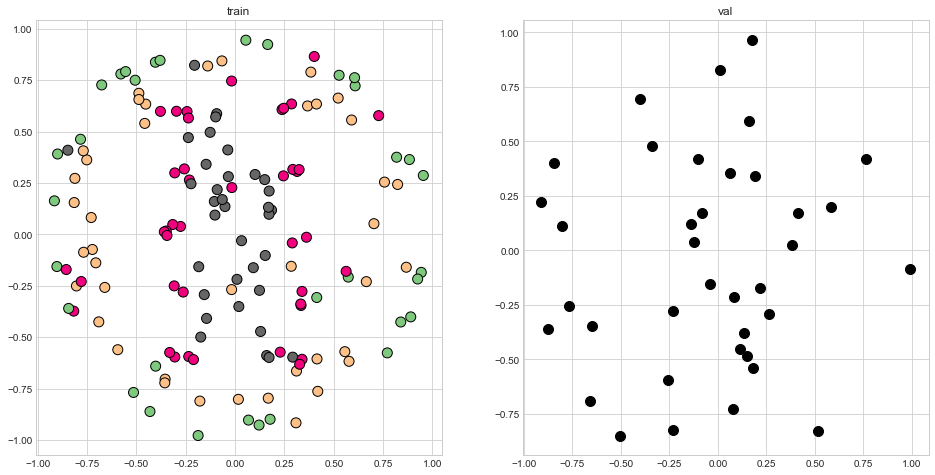

In [6]:
import pandas as pd

df_train = pd.read_csv('train.csv')
X_toy_train = df_train.values[:, 1:3]
y_toy_train = df_train.Competitor.map({'Bob': 0, 'Sue': 1, 'Kate': 2, 'Mark': 3}).values

df_val = pd.read_csv('test.csv')
X_toy_val = df_val.values[:, 1:3]
y_toy_val = df_val.Competitor.map({'Bob': 0, 'Sue': 1, 'Kate': 2, 'Mark': 3}).values

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.title('train')
plt.scatter(X_toy_train[:, 0], X_toy_train[:, 1], c=y_toy_train, edgecolors='k', linewidths=1, s=100, cmap='Accent')
plt.subplot(1, 2, 2)
plt.title('val')
plt.scatter(X_toy_val[:, 0], X_toy_val[:, 1], c='k', edgecolors='k', linewidths=1, s=100, cmap='Accent')
plt.show()

### 1.2. Загрузка моделей и вспомогательных функций

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [3]:
def calc_accuracy(model, X, y_true):
    y_pred = model.predict(X)
    accuracy = (y_true == y_pred).mean()
    return accuracy

def get_grid(data):
    x_min, x_max = data[:, 0].min() - 0.1, data[:, 0].max() + 0.1
    y_min, y_max = data[:, 1].min() - 0.1, data[:, 1].max() + 0.1
    return np.meshgrid(np.arange(x_min, x_max, 0.001),
                       np.arange(y_min, y_max, 0.001))

def plot_model(X, y, clf, proba=False, title='', n_classes=None):
    xx, yy = get_grid(X)
    if proba:
        predicted = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
    else:
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.figure(figsize=(10, 10))    
    plt.title(title)
    plt.pcolormesh(xx, yy, predicted, alpha=0.7, cmap='Accent', vmax=n_classes-1 if n_classes is not None else None)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=100, edgecolors='k', linewidths=1, cmap='Accent')
    plt.ylim([yy.min(),yy.max()])
    plt.xlim([xx.min(),xx.max()])
    plt.show()

### 1.3. Построение базовых моделей
Возьмем три типа моделей: 
* "деревянную" (`DecisionTreeClassifier`)
* метрическую (`kNeighborsClassifier`)
* линейную (`LogisticRegression`).

Обучим каждую из них на тренировочной части данных, оценим качество и отрисуем разделение признакового пространства этими классификаторами:

In [8]:
tree = DecisionTreeClassifier(random_state=2, max_depth=5)
knn = KNeighborsClassifier(n_neighbors=1)
logreg = LogisticRegression(random_state=2, multi_class='auto', solver='lbfgs')

for model_name, model in zip(('DecisionTree', 'kNN(k=1)', 'LogReg'), (tree, knn, logreg)):
    model.fit(X_toy_train, y_toy_train)
    train_accuracy = calc_accuracy(model, X_toy_train, y_toy_train)
    val_accuracy = calc_accuracy(model, X_toy_val, y_toy_val)
    print('Accuracy of {}: train {:.3f}, val {:.3f}'.format(model_name, train_accuracy, val_accuracy))
    #plot_model(X_toy_train, y_toy_train, model, title=model_name, n_classes=4)    

Accuracy of DecisionTree: train 0.860, val 0.730
Accuracy of kNN(k=1): train 1.000, val 0.703
Accuracy of LogReg: train 0.347, val 0.216


Как мы видим, лучше остальных с классификацией справилось дерево, а вот линейная модель без настройки оказалось очень плоха - точность ее предсказаний на валидационной подвыборке хуже, чем у случайного гадания (при 4 классах это 25%). 

## 2. Блендинг
### 2.1. Реализация класса для блендинга

Вспомним, как устроен процесс построения блендинга моделей:
1. Обучающая выборка делится на две части: `A` и `B`, тестовая выборка - `C`.
2. Выбираются несколько базовых моделей
3. Каждая из базовых моделей обучается на выборке `A` и делает предсказания для `B` и `C` (предсказания вероятностей каждого из классов)
4. Мета-модель обучается на полученных мета-признаках `B` и делает предсказания на полученных мета-признаках `C`.

In [7]:
class Blending(object):
    
    def __init__(self, meta_size=0.5):
        """
        Initialize Blending class.
        :param meta_size: size of dataset 'B' for training meta-model.
        """
        self.meta_size = meta_size
        self.base_estimators = []
        self.meta_estimator = None
    
    def fit(self, base_estimators, meta_estimator, X, y):
        """
        Run training process for base models and for meta-model after.
        :param base_estimators: list of estimator instances (must have .fit() and .predict_proba() methods)
        :param meta_estimator: estimator instance for meta-model (must have .fit() and .predict_proba() methods)
        :param X: array-like features (n_obj x n_features)
        :param y: array-like targets 
        """
        self.base_estimators = base_estimators
        self.meta_estimator = meta_estimator
        
        # Split the train data in 2 parts, A and B
        X_train_A, X_train_B, y_train_A, y_train_B = tts(X, y, test_size=self.meta_size, random_state=2)
        
        # TODO: Train each of base_estimators on A and using the to generate meta-features of B
        meta_features_train = []
        
        # Fit the meta-model on meta-features of B
        self.meta_estimator.fit(meta_features_train, y_train_B)
    
    def predict(self, X):
        """
        Run prediction of meta-model for X.
        :param X: array-like features (n_obj x n_features)
        :return predictions:
        """
        meta_features = []
        # TODO: Generate meta-features of X (C) using base models 
        
        # Predict targets for meta-features of X (C) using meta-model
        return self.meta_estimator.predict(meta_features)

### 2.2. Построение блендинга моделей
В качестве базовых моделей возьмем все те же дерево, kNN и логрегрессию, в качестве мета-алгоритма - также логистическую регрессию.

In [8]:
tree = DecisionTreeClassifier(random_state=2, max_depth=5)
knn = KNeighborsClassifier(n_neighbors=1)
logreg = LogisticRegression(random_state=2, multi_class='auto', solver='lbfgs')

blender = Blending()
logreg_meta = LogisticRegression(random_state=2, solver='lbfgs', multi_class='auto')
blender.fit(base_estimators=(tree, knn, logreg), meta_estimator=logreg_meta, 
            X=X_toy_train, y=y_toy_train)

Accuracy of Blending: train 0.847, val 0.784


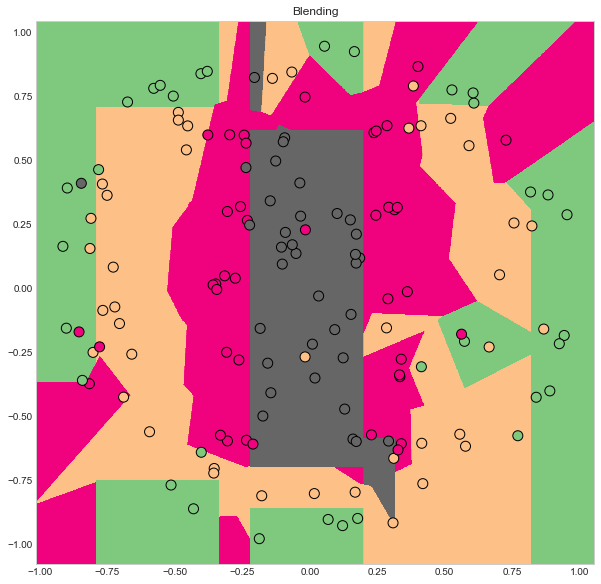

In [9]:
train_accuracy = calc_accuracy(blender, X_toy_train, y_toy_train)
val_accuracy = calc_accuracy(blender, X_toy_val, y_toy_val)
print('Accuracy of {}: train {:.3f}, val {:.3f}'.format('Blending', train_accuracy, val_accuracy))
plot_model(X_toy_train, y_toy_train, blender, title='Blending', n_classes=4)

При блендинге получаем интересную картину разбиения признакового пространства: теперь в нем присутствуют как элементы разбиения деревом, так и элементы разбиения методом ближайших соседей (**найдите их на картинке**). Что характерно, вклада от линейной модели не наблюдается.

Общее качество мета-модели немного выше, чем у лучшей из моделей (0.784 против 0.730 у дерева).

Посмотрим на абсолютные значения весов мета-модели (по сути, это коэффициенты логистической регрессии перед вероятностями 4 классов каждой из 3 моделей). 
Интуиция подсказывает, что блендинг должен был не учитывать вклад самой слабой из моделей (в нашем случае, логистической регрессии):

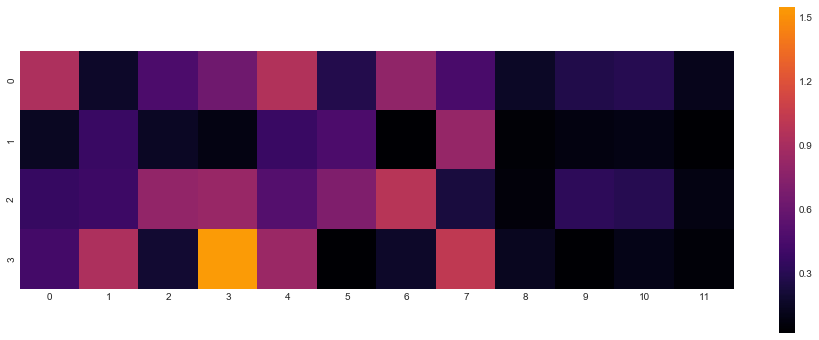

In [10]:
plt.figure(figsize=(16, 6))
coef_map = sns.heatmap(np.abs(blender.meta_estimator.coef_), center=True, cmap='inferno', square=True)

Картинка выше устроена следующим образом: 
* строчка `i` - это набор весов логрегрессии для `i`-го класса
* столбец `j` - это набор весов логрегрессии для одного из классов одного из алгоритмов

Проще говоря, первые 4 столбца - это веса для предсказаний 1-й базовой модели (дерево), следующие 4 столбца - веса для предсказаний 2-й базовой модели (kNN), последние 4 - веса для ответов базовой линейной модели. 

Как хорошо видно, абсолютное значение весов (чем темнее ячейка, тем ближе значение модуля соответствующего веса к 0) у базовой логрегрессии очень низкое (последние 4 столбца сильно темнее остальных групп). Это и означает, что мета-модель мало внимания обращает на результаты линейной модели и больше - на результаты дерева и kNN.

### 2.3. Модификация данных
Как мы говорили на лекции, не всегда построние мета-алгоритма сразу же дает прирост качества. Для того, чтобы мета-модель "взлетела", может потребоваться:
* Почистить / модифицировать данные (добавить комбинацию признаков, сделать нормализацию, ...)
* Произвести настройку гиперпараметров отдельных моделей
* Подобрать модель и ее параметры для мета-алгоритма

Сейчас сделаем следующее: добавим новый признак, определяющий расстояние от объекта до начала координат (из картинки с данными видно, что в них имеется радиальная структура) - кажется, что это должно помочь.

In [11]:
X_toy_train_rad = np.sqrt((X_toy_train[:, 0] ** 2 + X_toy_train[:, 1] ** 2).astype(np.float32))[:, np.newaxis]
X_toy_train_upd = np.concatenate((X_toy_train, X_toy_train_rad), axis=1)

X_toy_val_rad = np.sqrt((X_toy_val[:, 0] ** 2 + X_toy_val[:, 1] ** 2).astype(np.float32))[:, np.newaxis]
X_toy_val_upd = np.concatenate((X_toy_val, X_toy_val_rad), axis=1)

Теперь повторим процедуру - обучим и оценим качество базовых моделей, а потом смешаем их в блендинг (все параметры оставим прежними, поменяем только данные):

In [15]:
tree = DecisionTreeClassifier(random_state=2, max_depth=5)
knn = KNeighborsClassifier(n_neighbors=1)
log_reg = LogisticRegression(random_state=2, multi_class='auto', solver='lbfgs')

for model_name, model in zip(('DecisionTree', 'kNN(k=1)', 'LogReg'), (tree, knn, logreg)):
    model.fit(X_toy_train_upd, y_toy_train)
    train_accuracy = calc_accuracy(model, X_toy_train_upd, y_toy_train)
    val_accuracy = calc_accuracy(model, X_toy_val_upd, y_toy_val)
    print('Accuracy of {}: train {:.3f}, val {:.3f}'.format(model_name, train_accuracy, val_accuracy))

Accuracy of DecisionTree: train 0.927, val 0.892
Accuracy of kNN(k=1): train 1.000, val 0.730
Accuracy of LogReg: train 0.553, val 0.541


In [16]:
tree = DecisionTreeClassifier(random_state=2, max_depth=5)
knn = KNeighborsClassifier(n_neighbors=1)
logreg = LogisticRegression(random_state=2, multi_class='auto', solver='lbfgs')

blender = Blending()
logreg_meta = LogisticRegression(random_state=2, solver='lbfgs', multi_class='auto')
blender.fit(base_estimators=(tree, knn, logreg), meta_estimator=logreg_meta, 
            X=X_toy_train_upd, y=y_toy_train)

Accuracy of Blending: train 0.893, val 0.865


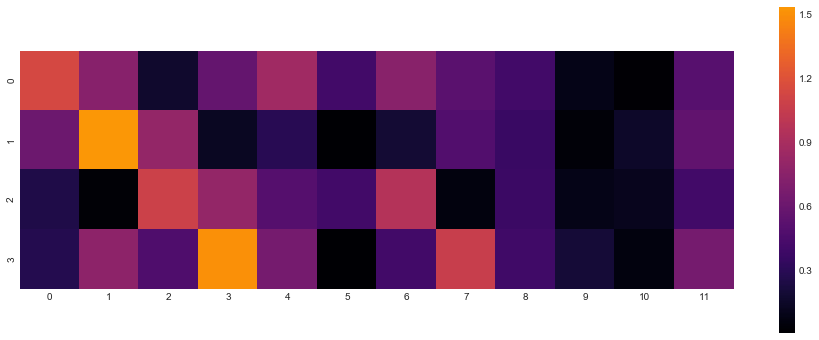

In [17]:
train_accuracy = calc_accuracy(blender, X_toy_train_upd, y_toy_train)
val_accuracy = calc_accuracy(blender, X_toy_val_upd, y_toy_val)
print('Accuracy of {}: train {:.3f}, val {:.3f}'.format('Blending', train_accuracy, val_accuracy))

plt.figure(figsize=(16, 6))
coef_map = sns.heatmap(np.abs(blender.meta_estimator.coef_), center=True, cmap='inferno', square=True)

Получилось, что с новым признаков базовая линейная модель работает лучше (точность на валидации выросла более, чем в 2 раза!), что также отразилось и в увеличении весов мета-модели, соответствующих базовой линейной модели (последние 4 столбца - стало меньше "черноты"). 
Однако, общее качество блендинга стало хуже, чем дает лучшая из базовых моделей (0.865 против 0.892 у дерева) - это, опять же, показывает, что его нужно настраивать.

## 3. Стекинг
### 3.1. Реализация класса для стекинга

Вспомним, как устроен процесс построения блендинга моделей:
1. Обучающая выборка `A` делится на N частей (фолдов) (`A_i, 1 <= i <= N`),  тестовая выборка - `C`.
2. Выбираются несколько базовых моделей
3. На каждом из фолдов делаются предсказания (мета-признаки) базовых моделей, обученных на остальных N-1 фолдах
4. Все базовые модели обучаются на всей выборке `A` и делают предсказания (мета-признаки) для `C`
5. Мета-модель обучается на мета-признаках обучающей выборки (из п.3) и делает предсказания для тестовой на основе ее мета-признаков (из п.4)

In [19]:
from sklearn.model_selection import KFold

In [21]:
class Stacking(object):
    
    def __init__(self, num_folds=3):   
        """
        Initialize Blending class.
        :param num_folds: number of folds to use for meta-features generating.
        """
        self.kfold = KFold(n_splits=num_folds, shuffle=True, random_state=2)
        self.base_estimators = []
        self.meta_estimator = None
    
    def fit(self, base_estimators, meta_estimator, X, y):
        """
        Run training process for base models and for meta-model after.
        :param base_estimators: list of estimator instances (must have .fit() and .predict_proba() methods)
        :param meta_estimator: estimator instance for meta-model (must have .fit() and .predict_proba() methods)
        :param X: array-like features (n_obj x n_features)
        :param y: array-like targets 
        """
        self.base_estimators = base_estimators
        self.meta_estimator = meta_estimator
        
        meta_features = []
        meta_labels = []
        
        # For each fold train all base models on other num_folds-1 folds and generate meta-features for it
        folds = self.kfold.split(X)
        for train_idxs, pred_idxs in folds:
            X_train = X[train_idxs]
            y_train = y[train_idxs]
            X_pred = X[pred_idxs]
            y_pred = y[pred_idxs]
            meta_labels.append(y_pred)
            
            fold_predictions = []
            for estimator in self.base_estimators:
                estimator.fit(X_train, y_train)
                fold_predictions.append(estimator.predict_proba(X_pred))
            meta_features.append(np.asarray(fold_predictions).transpose(1, 0, 2).reshape(X_pred.shape[0], -1))
        
        # Collect all generated meta-features and labels for them
        meta_features = np.concatenate(meta_features)
        meta_labels = np.concatenate(meta_labels)
        
        # Re-fit all base models on the whole dataset
        for estimator in self.base_estimators:
            estimator.fit(X, y)
        
        # Fit the meta-model on meta-features of A
        self.meta_estimator.fit(meta_features, meta_labels)

    
    def predict(self, X):
        meta_features = []
        
        # Generate meta-features of X (C) using base models 
        for estimator in self.base_estimators:
            meta_features.append(estimator.predict_proba(X))
        meta_features = np.asarray(meta_features).transpose(1, 0, 2).reshape(X.shape[0], -1)
        
        # Predict targets for meta-features of X (C) using meta-model
        return self.meta_estimator.predict(meta_features)

### 3.2. Построение стекинга моделей
В качестве базовых моделей возьмем все те же дерево, kNN и логрегрессию, в качестве мета-алгоритма - также логистическую регрессию.
Будем для начала использовать исходную выборку (без дополнительного признака). Начнем с числа разбиений = 3:

In [22]:
tree = DecisionTreeClassifier(random_state=2, max_depth=5)
knn = KNeighborsClassifier(n_neighbors=1)
log_reg = LogisticRegression(random_state=2, multi_class='auto', solver='lbfgs')

stacker = Stacking(3)
logreg_meta = LogisticRegression(solver='lbfgs', random_state=2, multi_class='auto')
stacker.fit(base_estimators=(tree, knn, logreg), meta_estimator=logreg_meta, 
            X=X_toy_train, y=y_toy_train)

Accuracy of Stacking: train 0.967, val 0.784


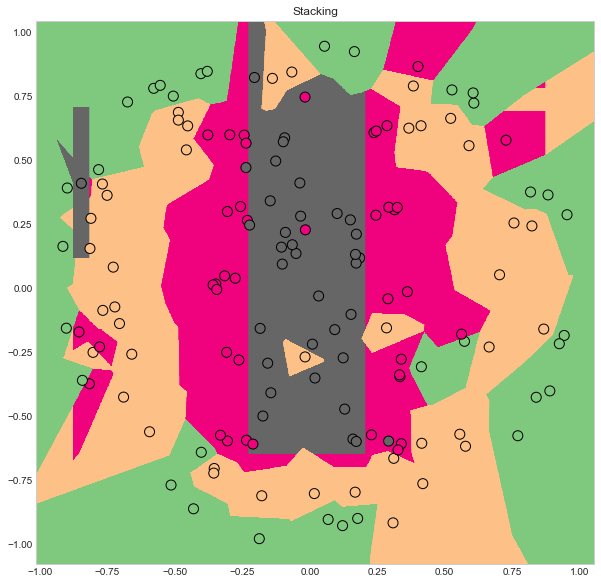

In [23]:
train_accuracy = calc_accuracy(stacker, X_toy_train, y_toy_train)
val_accuracy = calc_accuracy(stacker, X_toy_val, y_toy_val)
print('Accuracy of {}: train {:.3f}, val {:.3f}'.format('Stacking', train_accuracy, val_accuracy))
plot_model(X_toy_train, y_toy_train, stacker, title='Stacking', n_classes=4)

Получили, что на наших данных стекинг без настройки и с 3 фолдами достигает того же качества, что и блендинг (на тех же базовых моделях).

### 3.3. Подбор числа фолдов для стекинга

Подберем число фолдов для разбиения при стекинге, будем использовать выборку с дополнительным признаком:

In [24]:
def plot_accuracies(param_name, param_values, train_accuracies, val_accuracies, log_x=False):
    plt.figure(figsize=(16, 8))
    plt.plot(param_values, train_accuracies, 'o-', label='train')
    plt.plot(param_values, val_accuracies, 'o-', label='val')

    plt.xlabel(param_name)
    if log_x:
        plt.xscale('log')
    plt.ylabel('accuracy')
    plt.legend(loc='best')
    plt.title(param_name)
    plt.show()

100%|██████████| 8/8 [00:00<00:00, 13.91it/s]


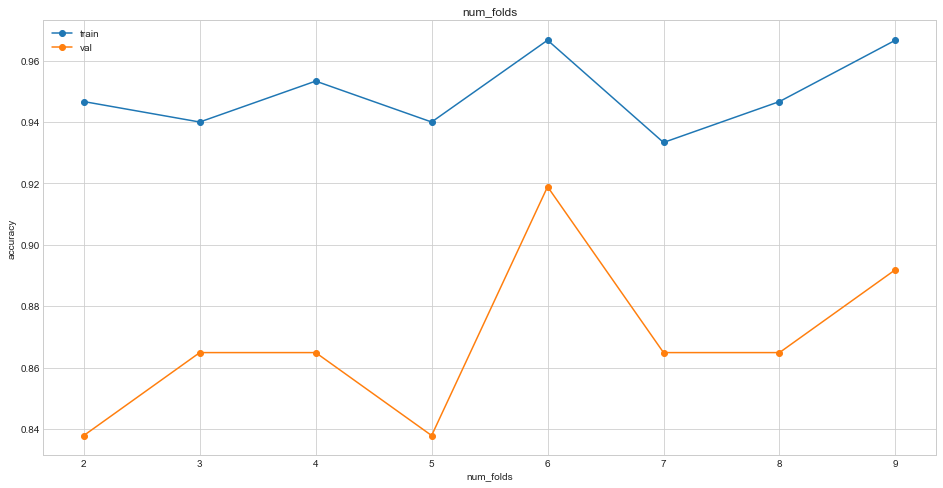

Best val accuracy: 0.918918918918919 (at 6)


In [25]:
num_folds_range = range(2, 10)
train_accuracies = []
val_accuracies = []

for num_folds in tqdm.tqdm(num_folds_range):
    tree = DecisionTreeClassifier(random_state=2, max_depth=5)
    knn = KNeighborsClassifier(n_neighbors=1)
    log_reg = LogisticRegression(random_state=2, multi_class='auto', solver='lbfgs')

    stacker = Stacking(num_folds=num_folds)
    logreg_meta = LogisticRegression(solver='lbfgs', random_state=2, multi_class='auto')
    stacker.fit(base_estimators=(tree, knn, logreg), meta_estimator=logreg_meta, 
                X=X_toy_train_upd, y=y_toy_train)
    
    train_accuracies.append(calc_accuracy(stacker, X_toy_train_upd, y_toy_train))
    val_accuracies.append(calc_accuracy(stacker, X_toy_val_upd, y_toy_val))
plot_accuracies('num_folds', num_folds_range, train_accuracies, val_accuracies)
best_idx = np.argmax(val_accuracies)
best_val_accuracy = val_accuracies[best_idx]
print('Best val accuracy: {} (at {})'.format(best_val_accuracy, num_folds_range[best_idx]))

**Получили, что при числе фолдов = 6 точность на валидации составляет 92% (против 86.5% у блендинга на тех же признаках)!**

Посмотрим на веса стекинга поверх отдельных моделей:

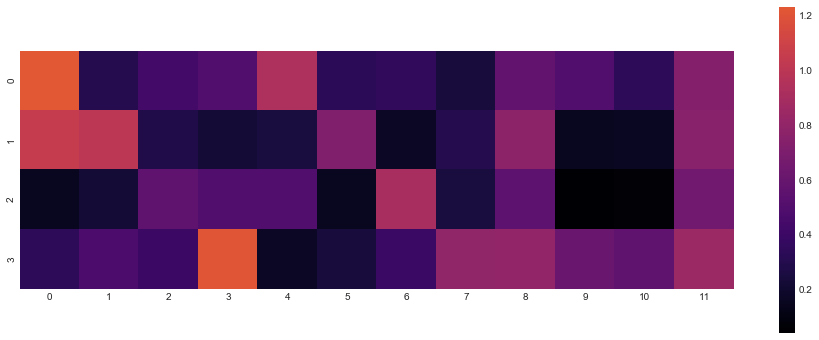

In [26]:
plt.figure(figsize=(16, 6))
coef_map = sns.heatmap(np.abs(stacker.meta_estimator.coef_), center=True, cmap='inferno', square=True)

## Самостоятельно + дома:

1. Добавьте другие модели в качестве базовых для стекинга (`SVM` с различными ядрами, `Random Forest`, `kNN` с различными `k`). Найдите комбинацию базовых моделей, которая дает лучший результат на валидации при использовании логистической регрессии в качестве мета-алгоритма.
2. Зафиксировав набор базовых моделей из п.1, попробуйте настроить мета-алгоритм, подобрав его гиперпараметры (особенно регуляризацию). 